In [1]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

In [2]:
import numpy as np
import torch, torchvision
from torchvision import transforms as tr
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings

from copy import deepcopy

In [3]:
from sklearn import svm, preprocessing
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def get_labels(fname):
#     example fname: truck_30_pivothead_rzminus.mp4
    fnparts = fname.split('.')[0].split('_')
    category = fnparts[0]
    identity = category+fnparts[1]
    trans = fnparts[3]
    return category, identity, trans

def get_categorylabel(fname):
    fnparts = fname.split('.')[0].split('_')
    category = fnparts[0]
    return category

def get_identitylabel(fname):
    fnparts = fname.split('.')[0].split('_')
    category = fnparts[0]
    identity = category+fnparts[1]
    return identity

def get_translabel(fname):
    fnparts = fname.split('.')[0].split('_')
    translabel = fnparts[3]
    return translabel

def add_labels_to_df(df, labels):
    if 'category' in labels:
        df['category'] = df['fnames'].apply(lambda fname: get_categorylabel(fname))
    if 'identity' in labels:
        df['identity'] = df['fnames'].apply(lambda fname: get_identitylabel(fname))
    if 'transformation' in labels:
        df['transformation'] = df['fnames'].apply(lambda fname: get_translabel(fname))
    return df

In [6]:
def get_separability_score(df, label, method='sgd', ret_preds=False):
    # method: sgd or svm
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(df[label])
    
    X_cols = ['dim'+str(i)
              for i in range(768)]
    X = df[X_cols]
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    if method=='svm':
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(random_state=0, tol=1e-4))
    elif method=='sgd':
        clf = make_pipeline(StandardScaler(),
                            SGDClassifier(max_iter=1000, tol=1e-4, n_jobs=30))#, loss='log_loss'))
    else:
        raise ValueError()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test,y_test)
    if ret_preds:
        preds = clf.predict(X_test)
        return train_score, test_score, preds, y_test
    return train_score, test_score

In [7]:
def fix_fnames(df):
    df.iloc[2163,0] = 'giraffe_02_pivothead_rzplus.mp4'
    df.iloc[1851,0]='duck_06_pivothead_rxminus.mp4'
    df.iloc[751,0] = 'car_03_pivothead_rzminus.mp4'
    return df

def eval_embs(fp, method='sgd', ret_preds=False):
    scores = {}
    
    df = pd.read_csv(fp)

#     fix 3 filenames. for older files
    df = fix_fnames(df)
    df = add_labels_to_df(df, ['category', 'identity','transformation'])
    
#     if ret_preds
    scores['category'] = get_separability_score(df, 'category', method=method)
#     scores['identity'] = get_separability_score(df, 'identity', method=method)
    scores['transformation'] = get_separability_score(df, 'transformation', method=method)
    return scores

In [8]:
def get_seed(fp):
    stem = Path(fp).stem
    parts = stem.split('_')
    return parts[3]

def get_tag(fp):
    # g0g1g2, g2g1g0, g3g1g2, grgrgr, g2g2g2
    # g0, g2, g3, gr
    # g0g1, g2g1, g2g2, grgr, g3g1
    stem = Path(fp).stem
    parts = stem.split('_')
    glast = parts[1]
    
    if 'pre' in stem:
        gpre = parts[-1]
        gpre = gpre.replace('pre.', '')
        
        full_tag = gpre+glast
    else:
        full_tag = glast
        
    return full_tag

def proc_fp(fp, score_type):
    df = pd.read_csv(fp)
    df = fix_fnames(df)
    df = add_labels_to_df(df, ['category', 'identity','transformation'])
    method='sgd'
    train_score, test_score, preds, targets = get_separability_score(df, score_type, method=method, ret_preds=True)
    return test_score

def get_ablation_cond(fp):
    stem = Path(fp).stem
    parts = stem.split('_')
#     other_id = parts[5]
    cond = parts[4]
    return cond


tagname_dict = {
    'g0':'g0g1g2', 
    'g0g1': 'g0g1g2', 
    'g0g1g2': 'g0g1g2',
    'g2':'g2g1g0', 
    'g2g1': 'g2g1g0', 
    'g2g1g0': 'g2g1g0'}

## Make the default condition

In [9]:
default_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/'#s3/'


In [10]:
def_record_list = []
iter_per_stage = 5000
for stage in range(1,4):
    emb_dir = default_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         print(tag)
        if ('gr' in tag) |\
    ('g3' in tag) |\
    ('g0g0' in tag) |\
    ('g2g2' in tag):
            continue # skip other curricula
        
#         curr = tagname_dict[tag]
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': tag,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        def_record_list.append(deepcopy(record))
df_def = pd.DataFrame.from_records(def_record_list)
# df_def = df_def.rename(columns={
#     'tag': 'Curriculum',
#     'iteration': 'Iteration'
# })
df_def

100%|███████████████████████████████████████████| 21/21 [00:12<00:00,  1.65it/s]


,fname,Curriculum,Iteration,Accuracy
0,embeddings_g2_seed_212_sgd,g2,5000,0.269339
1,embeddings_g0_seed_662__sgd,g0,5000,0.389592
2,embeddings_g0_seed_213_sgd,g0,5000,0.362166
3,embeddings_g2_seed_211_sgd,g2,5000,0.225035
4,embeddings_g2_seed_563__sgd,g2,5000,0.266526
5,embeddings_g2_seed_213_sgd,g2,5000,0.261603
6,embeddings_g0_seed_661__sgd,g0,5000,0.412799
7,embeddings_g0_seed_212_sgd,g0,5000,0.356540
8,embeddings_g2_seed_561__sgd,g2,5000,0.274262
9,embeddings_g2_seed_562__sgd,g2,5000,0.259494


In [16]:
defsp_record_list = []
iter_per_stage = 5000
for stage in range(1,4):
    emb_dir = default_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         print(tag)
        if ('gr' in tag) |\
    ('g3' in tag) |\
    ('g0g0' in tag) |\
    ('g2g2' in tag):
            continue # skip other curricula
        
#         curr = tagname_dict[tag]
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': tag,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        defsp_record_list.append(deepcopy(record))
df_defsp = pd.DataFrame.from_records(defsp_record_list)
# df_def = df_def.rename(columns={
#     'tag': 'Curriculum',
#     'iteration': 'Iteration'
# })
df_defsp

  0%|                                                    | 0/21 [00:00<?, ?it/s]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
100%|███████████████████████████████████████████| 21/21 [00:11<00:00,  1.76it/s]


,fname,Curriculum,Iteration,Accuracy
0,embeddings_g2_seed_212_sgd,g2,5000,0.405767
1,embeddings_g0_seed_662__sgd,g0,5000,0.518987
2,embeddings_g0_seed_213_sgd,g0,5000,0.455696
3,embeddings_g2_seed_211_sgd,g2,5000,0.434599
4,embeddings_g2_seed_563__sgd,g2,5000,0.447257
5,embeddings_g2_seed_213_sgd,g2,5000,0.427567
6,embeddings_g0_seed_661__sgd,g0,5000,0.514065
7,embeddings_g0_seed_212_sgd,g0,5000,0.480309
8,embeddings_g2_seed_561__sgd,g2,5000,0.464838
9,embeddings_g2_seed_562__sgd,g2,5000,0.436006


## Frame Rate

In [18]:
# Prepare a copy of df_def with the condition column added

dfdef_fr = deepcopy(df_def)
dfdef_fr['Condition'] = '30fps'

In [19]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/frame_rate/'

In [ ]:
record_list = []
iter_per_stage = 5000 #@@
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_fr = pd.DataFrame.from_records(record_list)
df_fr

In [ ]:
df_fr = pd.concat((df_fr, dfdef_fr)) #add the default condition
df_fr

In [31]:
# shades_blue = ["#377eb8"]*3 # "#6baed6", "#9ecae1"]
# shades_orange = ["#e6550d"]*3#, "#fd8d3c", "#fdae6b"]

# Combine the shades into a single color palette
# custom_palette = shades_blue + shades_orange

In [37]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['10fps','15fps','30fps']

In [40]:
# df_all['Curriculum'].map(tagname_dict)
# df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)

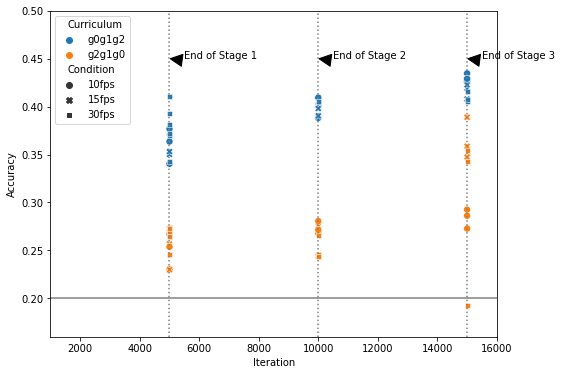

In [42]:
# df_all = deepcopy(df_fr)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')


ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')
ax.axvline(x=15000, color='gray', linestyle=':')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_sup_toybox_categorization_framerate.pdf', dpi=300)

## Number of Iterations

In [43]:
# Prepare a copy of df_def with the condition column added

dfdef_niter = deepcopy(df_def)
dfdef_niter['Condition'] = 'nep5'

In [44]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/num_ep/'

In [48]:
# # fix the filenames
# for stage in range(1,4):
#     emb_dir = emb_root+'s'+str(stage)+'/'
#     directory = emb_dir
#     for filename in os.listdir(directory):
#         if 'sgd' in filename:
#             new_filename = filename.replace('sgd', 'nep2')
#             old_path = os.path.join(directory, filename)
#             new_path = os.path.join(directory, new_filename)
#             os.rename(old_path, new_path)


In [ ]:
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
        
        if cond=='nep2':
            iter_per_stage = 2000 #@@
        elif cond=='nep5':
            iter_per_stage = 5000 #@@
        elif cond=='nep15':
            iter_per_stage = 15000 #@@
        
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_niter = pd.DataFrame.from_records(record_list)
df_niter = pd.concat((df_niter, dfdef_niter)) #add the default condition
df_niter

In [53]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['nep2','nep5','nep15']

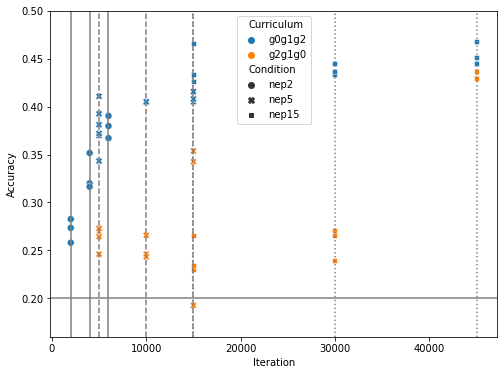

In [66]:
df_all = deepcopy(df_niter)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')


ax.axvline(x=2000, color='gray', linestyle='solid')
ax.axvline(x=4000, color='gray', linestyle='solid')
ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dashed')
ax.axvline(x=10000, color='gray', linestyle='dashed')
ax.axvline(x=15000, color='gray', linestyle='dashed')

ax.axvline(x=15000, color='gray', linestyle='dotted')
ax.axvline(x=30000, color='gray', linestyle='dotted')
ax.axvline(x=45000, color='gray', linestyle='dotted')

# ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
#             arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
#             arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


plt.savefig('fig_sup_toybox_categorization_niter.pdf', dpi=300)

## Optimizer

In [67]:
# Prepare a copy of df_def with the condition column added

dfdef_optim = deepcopy(df_def)
dfdef_optim['Condition'] = 'sgd'

In [68]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/optim/'

In [69]:
iter_per_stage = 5000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_optim = pd.DataFrame.from_records(record_list)
df_optim = pd.concat((df_optim, dfdef_optim)) #add the default condition
df_optim

100%|███████████████████████████████████████████| 18/18 [00:29<00:00,  1.66s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g2_seed_223_adam,g2g1g0,adam,5000,0.094233
1,embeddings_g0_seed_233_adam,g0g1g2,adam,5000,0.338959
2,embeddings_g0_seed_221_adam,g0g1g2,adam,5000,0.109705
3,embeddings_g0_seed_231_adam,g0g1g2,adam,5000,0.284107
4,embeddings_g2_seed_223_adamw,g2g1g0,adamw,5000,0.412799
...,...,...,...,...,...
19,embeddings_g2_seed_212_sgd_pre.g0g1,g0g1g2,sgd,15000,0.405063
20,embeddings_g2_seed_213_sgd_pre.g0g1,g0g1g2,sgd,15000,0.407876
21,embeddings_g0_seed_213_sgd_pre.g2g1,g2g1g0,sgd,15000,0.353727
22,embeddings_g0_seed_211_sgd_pre.g2g1,g2g1g0,sgd,15000,0.192686


In [70]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['sgd','adam','adamw']

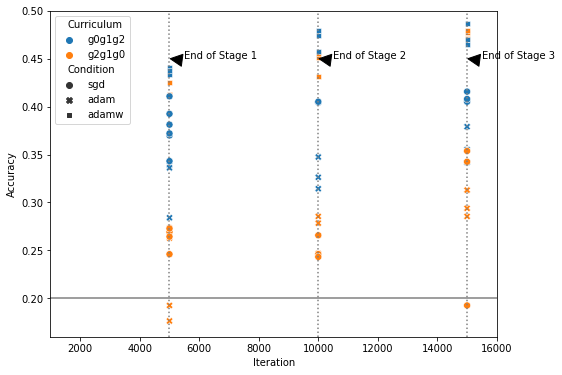

In [76]:
df_all = deepcopy(df_optim)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')


# ax.axvline(x=2000, color='gray', linestyle='solid')
# ax.axvline(x=4000, color='gray', linestyle='solid')
# ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dotted')
ax.axvline(x=10000, color='gray', linestyle='dotted')
ax.axvline(x=15000, color='gray', linestyle='dotted')

# ax.axvline(x=15000, color='gray', linestyle='dotted')
# ax.axvline(x=30000, color='gray', linestyle='dotted')
# ax.axvline(x=45000, color='gray', linestyle='dotted')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


plt.savefig('fig_sup_toybox_categorization_optim.pdf', dpi=300)

## Static Frame

In [24]:
# Prepare a copy of df_def with the condition column added

dfdef_static = deepcopy(df_def)
dfdef_static['Condition'] = 'video'

In [25]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/static_frame/'

In [15]:
ablation_cond = 'static'
iter_per_stage = 5000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = ablation_cond#get_ablation_cond(fp)
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_static = pd.DataFrame.from_records(record_list)
df_static = pd.concat((df_static, dfdef_static)) #add the default condition
df_static

100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.96s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_413_static,g0g1g2,static,5000,0.238397
1,embeddings_g0_seed_223_static,g0g1g2,static,5000,0.281997
2,embeddings_g1_seed_413_static_pre.g0,g0g1g2,static,10000,0.338959
3,embeddings_g1_seed_223_static_pre.g0,g0g1g2,static,10000,0.331927
4,embeddings_g2_seed_223_static_pre.g0g1,g0g1g2,static,15000,0.379044
5,embeddings_g2_seed_413_static_pre.g0g1,g0g1g2,static,15000,0.393108
0,embeddings_g2_seed_212_sgd,g2,video,5000,0.248242
1,embeddings_g0_seed_662__sgd,g0,video,5000,0.401547
2,embeddings_g0_seed_213_sgd,g0,video,5000,0.345992
3,embeddings_g2_seed_211_sgd,g2,video,5000,0.263010


In [16]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['video','static']

Text(15500, 0.45, 'End of Stage 3')

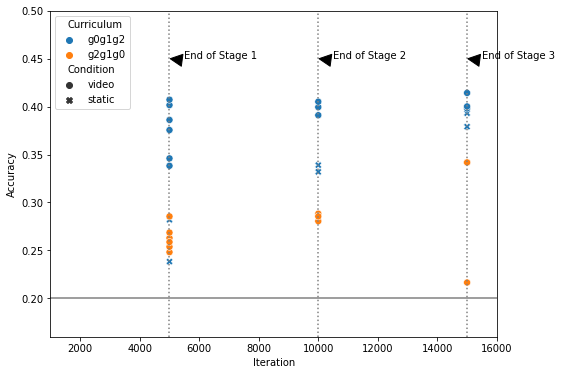

In [17]:
df_all = deepcopy(df_static)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')


# ax.axvline(x=2000, color='gray', linestyle='solid')
# ax.axvline(x=4000, color='gray', linestyle='solid')
# ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dotted')
ax.axvline(x=10000, color='gray', linestyle='dotted')
ax.axvline(x=15000, color='gray', linestyle='dotted')

# ax.axvline(x=15000, color='gray', linestyle='dotted')
# ax.axvline(x=30000, color='gray', linestyle='dotted')
# ax.axvline(x=45000, color='gray', linestyle='dotted')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_sup_toybox_categorization_static.pdf', dpi=300)

In [11]:
# Spatial transformation

dfdef_static_sp = deepcopy(df_defsp)
dfdef_static_sp['Condition'] = 'video'

In [12]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/static_frame/'

In [13]:
ablation_cond = 'static'
iter_per_stage = 5000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = ablation_cond#get_ablation_cond(fp)
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_static_sp = pd.DataFrame.from_records(record_list)
df_static_sp = pd.concat((df_static_sp, dfdef_static_sp)) #add the default condition
df_static_sp

100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_413_static,g0g1g2,static,5000,0.425457
1,embeddings_g0_seed_223_static,g0g1g2,static,5000,0.434599
2,embeddings_g1_seed_413_static_pre.g0,g0g1g2,static,10000,0.490155
3,embeddings_g1_seed_223_static_pre.g0,g0g1g2,static,10000,0.491561
4,embeddings_g2_seed_223_static_pre.g0g1,g0g1g2,static,15000,0.511955
5,embeddings_g2_seed_413_static_pre.g0g1,g0g1g2,static,15000,0.521800
0,embeddings_g2_seed_212_sgd,g2,video,5000,0.414909
1,embeddings_g0_seed_662__sgd,g0,video,5000,0.511252
2,embeddings_g0_seed_213_sgd,g0,video,5000,0.477496
3,embeddings_g2_seed_211_sgd,g2,video,5000,0.428270


In [14]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['video','static']

Text(15500, 0.45, 'End of Stage 3')

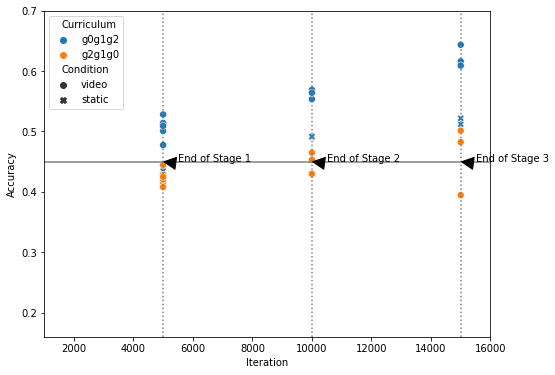

In [18]:
df_all = deepcopy(df_static_sp)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.45, color='gray', linestyle='solid')


# ax.axvline(x=2000, color='gray', linestyle='solid')
# ax.axvline(x=4000, color='gray', linestyle='solid')
# ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dotted')
ax.axvline(x=10000, color='gray', linestyle='dotted')
ax.axvline(x=15000, color='gray', linestyle='dotted')

# ax.axvline(x=15000, color='gray', linestyle='dotted')
# ax.axvline(x=30000, color='gray', linestyle='dotted')
# ax.axvline(x=45000, color='gray', linestyle='dotted')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.7])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_sup_toybox_categorization_static.pdf', dpi=300)

## Shuffle

In [11]:
# Prepare a copy of df_def with the condition column added

dfdef_shuff = deepcopy(df_def)
dfdef_shuff['Condition'] = 'ordered'

In [12]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/shuffle/'

In [13]:
ablation_cond = 'shuffled'
iter_per_stage = 5000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = ablation_cond#get_ablation_cond(fp)
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_shuff = pd.DataFrame.from_records(record_list)
df_shuff = pd.concat((df_shuff, dfdef_shuff)) #add the default condition
df_shuff

100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_363_shuffle,g0g1g2,shuffled,5000,0.322785
1,embeddings_g0_seed_361_shuffle,g0g1g2,shuffled,5000,0.339662
2,embeddings_g1_seed_363_shuffle_pre.g0,g0g1g2,shuffled,10000,0.387482
3,embeddings_g1_seed_361_shuffle_pre.g0,g0g1g2,shuffled,10000,0.405767
4,embeddings_g2_seed_363_shuffle_pre.g0g1,g0g1g2,shuffled,15000,0.421941
5,embeddings_g2_seed_361_shuffle_pre.g0g1,g0g1g2,shuffled,15000,0.416315
0,embeddings_g2_seed_212_sgd,g2,ordered,5000,0.269339
1,embeddings_g0_seed_662__sgd,g0,ordered,5000,0.389592
2,embeddings_g0_seed_213_sgd,g0,ordered,5000,0.362166
3,embeddings_g2_seed_211_sgd,g2,ordered,5000,0.225035


In [14]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['ordered','shuffled']

Text(15500, 0.45, 'End of Stage 3')

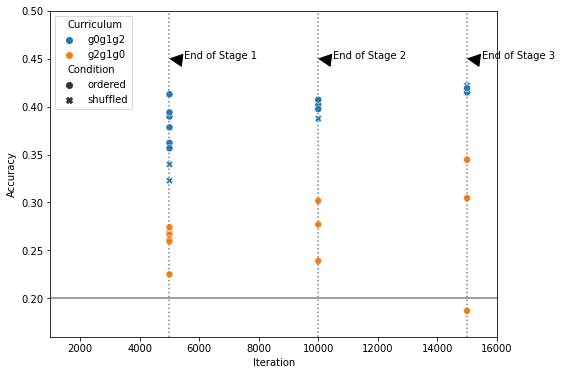

In [15]:
df_all = deepcopy(df_shuff)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')


# ax.axvline(x=2000, color='gray', linestyle='solid')
# ax.axvline(x=4000, color='gray', linestyle='solid')
# ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dotted')
ax.axvline(x=10000, color='gray', linestyle='dotted')
ax.axvline(x=15000, color='gray', linestyle='dotted')

# ax.axvline(x=15000, color='gray', linestyle='dotted')
# ax.axvline(x=30000, color='gray', linestyle='dotted')
# ax.axvline(x=45000, color='gray', linestyle='dotted')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_sup_toybox_categorization_static.pdf', dpi=300)

In [17]:
# Prepare a copy of df_def with the condition column added

dfdef_shuff_sp = deepcopy(df_defsp)
dfdef_shuff_sp['Condition'] = 'ordered'

In [18]:
ablation_cond = 'shuffled'
iter_per_stage = 5000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = ablation_cond#get_ablation_cond(fp)
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_shuff_sp = pd.DataFrame.from_records(record_list)
df_shuff_sp = pd.concat((df_shuff_sp, dfdef_shuff_sp)) #add the default condition
df_shuff_sp

100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.02s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_363_shuffle,g0g1g2,shuffled,5000,0.489451
1,embeddings_g0_seed_361_shuffle,g0g1g2,shuffled,5000,0.488748
2,embeddings_g1_seed_363_shuffle_pre.g0,g0g1g2,shuffled,10000,0.525316
3,embeddings_g1_seed_361_shuffle_pre.g0,g0g1g2,shuffled,10000,0.535162
4,embeddings_g2_seed_363_shuffle_pre.g0g1,g0g1g2,shuffled,15000,0.565401
5,embeddings_g2_seed_361_shuffle_pre.g0g1,g0g1g2,shuffled,15000,0.594937
0,embeddings_g2_seed_212_sgd,g2,ordered,5000,0.405767
1,embeddings_g0_seed_662__sgd,g0,ordered,5000,0.518987
2,embeddings_g0_seed_213_sgd,g0,ordered,5000,0.455696
3,embeddings_g2_seed_211_sgd,g2,ordered,5000,0.434599


Text(15500, 0.65, 'End of Stage 3')

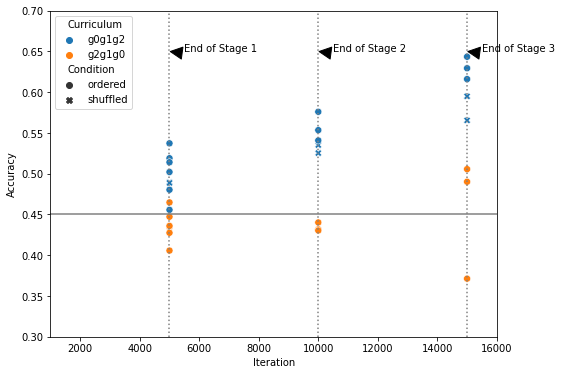

In [23]:
df_all = deepcopy(df_shuff_sp)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.45, color='gray', linestyle='solid')


# ax.axvline(x=2000, color='gray', linestyle='solid')
# ax.axvline(x=4000, color='gray', linestyle='solid')
# ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dotted')
ax.axvline(x=10000, color='gray', linestyle='dotted')
ax.axvline(x=15000, color='gray', linestyle='dotted')

# ax.axvline(x=15000, color='gray', linestyle='dotted')
# ax.axvline(x=30000, color='gray', linestyle='dotted')
# ax.axvline(x=45000, color='gray', linestyle='dotted')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.3,0.7])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.65), xytext=(5500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.65), xytext=(10500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.65), xytext=(15500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_sup_toybox_categorization_static.pdf', dpi=300)

## Slowness
10fps. 
static vs shuffle vs normal (default)

In [9]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/ablations/slowness/'

In [9]:
def get_ablation_cond(fp):
    stem = Path(fp).stem
    parts = stem.split('_')
#     other_id = parts[5]
    cond = parts[4]
    return cond

In [13]:
iter_per_stage = 5000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_slowness = pd.DataFrame.from_records(record_list)
# df_slowness = pd.concat((df_optim, dfdef_optim)) #add the default condition
df_slowness

100%|███████████████████████████████████████████| 15/15 [00:28<00:00,  1.93s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_682_default,g0g1g2,default,5000,0.369902
1,embeddings_g2_seed_683_shuffle,g2g1g0,shuffle,5000,0.222222
2,embeddings_g0_seed_683_shuffle,g0g1g2,shuffle,5000,0.284107
3,embeddings_g2_seed_683_default,g2g1g0,default,5000,0.230661
4,embeddings_g0_seed_681_default,g0g1g2,default,5000,0.343882
5,embeddings_g0_seed_681_static,g0g1g2,static,5000,0.374824
6,embeddings_g2_seed_681_shuffle,g2g1g0,shuffle,5000,0.248945
7,embeddings_g0_seed_683_default,g0g1g2,default,5000,0.345288
8,embeddings_g2_seed_682_default,g2g1g0,default,5000,0.282700
9,embeddings_g0_seed_681_shuffle,g0g1g2,shuffle,5000,0.313643


In [14]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['static','default','shuffle']

Text(15500, 0.45, 'End of Stage 3')

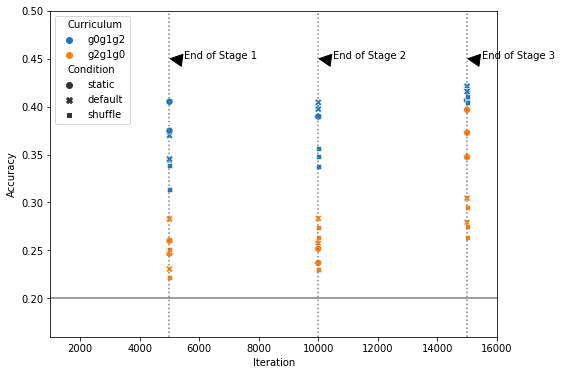

In [15]:
df_all = deepcopy(df_slowness)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')


# ax.axvline(x=2000, color='gray', linestyle='solid')
# ax.axvline(x=4000, color='gray', linestyle='solid')
# ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dotted')
ax.axvline(x=10000, color='gray', linestyle='dotted')
ax.axvline(x=15000, color='gray', linestyle='dotted')

# ax.axvline(x=15000, color='gray', linestyle='dotted')
# ax.axvline(x=30000, color='gray', linestyle='dotted')
# ax.axvline(x=45000, color='gray', linestyle='dotted')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_sup_toybox_categorization_static.pdf', dpi=300)

In [16]:
iter_per_stage = 5000 #@@
record_list = []
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
        if ('gr' in tag) |\
        ('g3' in tag) |\
        ('g0g0' in tag) |\
        ('g2g2' in tag):
                continue # skip other curricula
#         print(tag)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
        
#         tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))
df_slowness_sp = pd.DataFrame.from_records(record_list)
# df_slowness = pd.concat((df_optim, dfdef_optim)) #add the default condition
df_slowness_sp

 47%|████████████████████▌                       | 7/15 [00:09<00:11,  1.47s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
100%|███████████████████████████████████████████| 15/15 [00:24<00:00,  1.63s/it]


,fname,Curriculum,Condition,Iteration,Accuracy
0,embeddings_g0_seed_682_default,g0g1g2,default,5000,0.494374
1,embeddings_g2_seed_683_shuffle,g2g1g0,shuffle,5000,0.428973
2,embeddings_g0_seed_683_shuffle,g0g1g2,shuffle,5000,0.487342
3,embeddings_g2_seed_683_default,g2g1g0,default,5000,0.469761
4,embeddings_g0_seed_681_default,g0g1g2,default,5000,0.501406
5,embeddings_g0_seed_681_static,g0g1g2,static,5000,0.500000
6,embeddings_g2_seed_681_shuffle,g2g1g0,shuffle,5000,0.442335
7,embeddings_g0_seed_683_default,g0g1g2,default,5000,0.498594
8,embeddings_g2_seed_682_default,g2g1g0,default,5000,0.441632
9,embeddings_g0_seed_681_shuffle,g0g1g2,shuffle,5000,0.457103


Text(15500, 0.65, 'End of Stage 3')

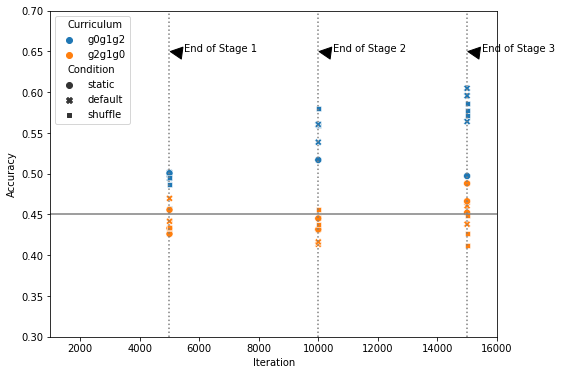

In [17]:
df_all = deepcopy(df_slowness_sp)
df_all['Curriculum'] = df_all['Curriculum'].map(tagname_dict)
cdata = df_all

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, linewidth=4.5,
#             hue_order=hue_order, style_order=style_order, palette=custom_palette)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.45, color='gray', linestyle='solid')


# ax.axvline(x=2000, color='gray', linestyle='solid')
# ax.axvline(x=4000, color='gray', linestyle='solid')
# ax.axvline(x=6000, color='gray', linestyle='solid')

ax.axvline(x=5000, color='gray', linestyle='dotted')
ax.axvline(x=10000, color='gray', linestyle='dotted')
ax.axvline(x=15000, color='gray', linestyle='dotted')

# ax.axvline(x=15000, color='gray', linestyle='dotted')
# ax.axvline(x=30000, color='gray', linestyle='dotted')
# ax.axvline(x=45000, color='gray', linestyle='dotted')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.3,0.7])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.65), xytext=(5500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.65), xytext=(10500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.65), xytext=(15500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_sup_toybox_categorization_static.pdf', dpi=300)

In [12]:
def get_separability_score(df, label, method='sgd', ret_preds=False):
    # method: sgd or svm
#     le = preprocessing.LabelEncoder()
    y = df[label] #le.fit_transform(df[label])
    
    X_cols = ['dim'+str(i)
              for i in range(768)]
    X = df[X_cols]
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    if method=='svm':
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(random_state=0, tol=1e-4))
    elif method=='sgd':
        clf = make_pipeline(StandardScaler(),
                            SGDClassifier(max_iter=1000, tol=1e-4, n_jobs=60))#, loss='log_loss'))
    else:
        raise ValueError()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test,y_test)
    if ret_preds:
        preds = clf.predict(X_test)
        return train_score, test_score, preds, y_test
    return train_score, test_score

In [13]:
def get_tag(fp):
    # g0g1g2, g2g1g0, g3g1g2, grgrgr, g2g2g2
    # g0, g2, g3, gr
    # g0g1, g2g1, g2g2, grgr, g3g1
    stem = Path(fp).stem
    parts = stem.split('_')
    glast = parts[2]
    
    if 'pre' in stem:
        gpre = parts[-1]
        gpre = gpre.replace('pre.', '')
        
        full_tag = gpre+glast
    else:
        full_tag = glast
    return full_tag

def get_ablation_cond(fp):
    stem = Path(fp).stem
    parts = stem.split('_')
#     other_id = parts[5]
    cond = parts[7]
    return cond

def proc_fp(fp):
    df = pd.read_csv(fp)
    
    method='sgd'
    train_score, test_score = get_separability_score(df, 'labels', method=method, ret_preds=False)
    return test_score

In [14]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/ucf101/ablations/slowness/'

In [15]:
record_list = []
iter_per_stage = 5000
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
        if Path(fp).stem.split('_')[1]=='na':
            continue
        tag = get_tag(fp)
        curr = tagname_dict[tag]
        cond = get_ablation_cond(fp)
        
        if (curr=='Youngest Only') | (curr=='Oldest Only'):
            continue
        tag = tag.replace('g3','ga')
        score = proc_fp(fp)
        record = {'fname': Path(fp).stem,
                  'tag': tag,
                  'Curriculum': curr,
                  'Condition': cond,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))

  0%|                                                    | 0/16 [00:00<?, ?it/s]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
  6%|██▊                                         | 1/16 [01:20<20:04, 80.33s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 12%|█████▌                                      | 2/16 [02:45<19:28, 83.45s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to impro

 53%|███████████████████████▍                    | 8/15 [08:59<08:16, 70.88s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 60%|██████████████████████████▍                 | 9/15 [09:36<06:01, 60.19s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 67%|████████████████████████████▋              | 10/15 [10:14<04:27, 53.41s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to impro

In [22]:
record_list

[{'fname': 'embeddings_model_g0_seed_683_other_683_shuffle',
  'tag': 'g0',
  'Curriculum': 'g0g1g2',
  'Iteration': 5000,
  'Accuracy': 0.17716624971571526},
 {'fname': 'embeddings_model_g2_seed_683_other_683_default',
  'tag': 'g2',
  'Curriculum': 'g2g1g0',
  'Iteration': 5000,
  'Accuracy': 0.1523766204230157},
 {'fname': 'embeddings_model_g0_seed_681_other_681_shuffle',
  'tag': 'g0',
  'Curriculum': 'g0g1g2',
  'Iteration': 5000,
  'Accuracy': 0.1742096884239254},
 {'fname': 'embeddings_model_g2_seed_681_other_681_shuffle',
  'tag': 'g2',
  'Curriculum': 'g2g1g0',
  'Iteration': 5000,
  'Accuracy': 0.16215601546508984},
 {'fname': 'embeddings_model_g2_seed_681_other_681_static',
  'tag': 'g2',
  'Curriculum': 'g2g1g0',
  'Iteration': 5000,
  'Accuracy': 0.16397543779849896}]

In [16]:
df_slowness_ucf= pd.DataFrame.from_records(record_list)
# df_slowness = pd.concat((df_optim, dfdef_optim)) #add the default condition
df_slowness_ucf

,fname,tag,Curriculum,Condition,Iteration,Accuracy
0,embeddings_model_g0_seed_683_other_683_shuffle,g0,g0g1g2,683,5000,0.176029
1,embeddings_model_g2_seed_683_other_683_default,g2,g2g1g0,683,5000,0.156698
2,embeddings_model_g0_seed_681_other_681_shuffle,g0,g0g1g2,681,5000,0.177621
3,embeddings_model_g2_seed_681_other_681_shuffle,g2,g2g1g0,681,5000,0.165113
4,embeddings_model_g2_seed_681_other_681_static,g2,g2g1g0,681,5000,0.164658
5,embeddings_model_g2_seed_683_other_683_static,g2,g2g1g0,683,5000,0.153059
6,embeddings_model_g0_seed_683_other_683_default,g0,g0g1g2,683,5000,0.244712
7,embeddings_model_g0_seed_681_other_681_default,g0,g0g1g2,681,5000,0.258131
8,embeddings_model_g2_seed_682_other_682_shuffle,g2,g2g1g0,682,5000,0.155788
9,embeddings_model_g2_seed_683_other_683_shuffle,g2,g2g1g0,683,5000,0.152604


In [21]:
df_slowness_ucf.to_csv('df_slowness_ucf.csv', index=False)

In [19]:
for index, row in df_slowness_ucf.iterrows():
    cond = row['fname'].split('_')[7]
#     print(cond)
    df_slowness_ucf.at[index, 'Condition'] = cond

In [20]:
df_slowness_ucf

,fname,tag,Curriculum,Condition,Iteration,Accuracy
0,embeddings_model_g0_seed_683_other_683_shuffle,g0,g0g1g2,shuffle,5000,0.176029
1,embeddings_model_g2_seed_683_other_683_default,g2,g2g1g0,default,5000,0.156698
2,embeddings_model_g0_seed_681_other_681_shuffle,g0,g0g1g2,shuffle,5000,0.177621
3,embeddings_model_g2_seed_681_other_681_shuffle,g2,g2g1g0,shuffle,5000,0.165113
4,embeddings_model_g2_seed_681_other_681_static,g2,g2g1g0,static,5000,0.164658
5,embeddings_model_g2_seed_683_other_683_static,g2,g2g1g0,static,5000,0.153059
6,embeddings_model_g0_seed_683_other_683_default,g0,g0g1g2,default,5000,0.244712
7,embeddings_model_g0_seed_681_other_681_default,g0,g0g1g2,default,5000,0.258131
8,embeddings_model_g2_seed_682_other_682_shuffle,g2,g2g1g0,shuffle,5000,0.155788
9,embeddings_model_g2_seed_683_other_683_shuffle,g2,g2g1g0,shuffle,5000,0.152604


In [22]:
hue_order = ['g0g1g2',
            'g2g1g0']
style_order=['static','default','shuffle']

Text(15500, 0.45, 'End of Stage 3')

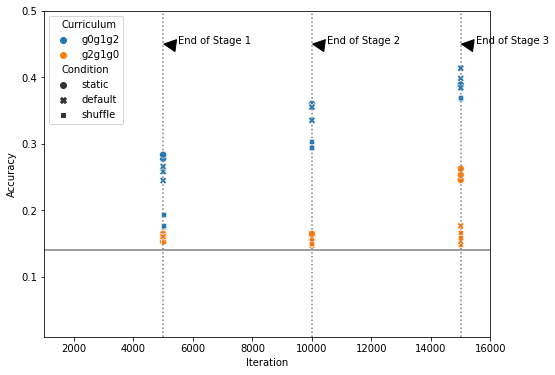

In [24]:
cdata=deepcopy(df_slowness_ucf)

fig,ax = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, linewidth=0.5,
#             hue_order=hue_order)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', style='Condition', ax=ax, 
                legend=True, s=50,
            hue_order=hue_order, style_order=style_order)#, palette=custom_palette)
ax.axhline(y=0.14, color='gray', linestyle='solid')


ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')
ax.axvline(x=15000, color='gray', linestyle=':')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.01,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_ucf.pdf', dpi=300)